TODO
- switch to python simulator

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from sklearn.linear_model import LinearRegression


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from HMM_matlab import hmmviterbi_vonmises, hmmdecode_vonmises
from hmm_utils import *
from simulation_matlab import *
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)


#### **Distortion matrix analysis with channel sweep**

This section looks at distortion matrix properties (axis-aligned shifts, rotations between X and Y subspaces) as a function of channel count.
For large d, we predict that:

$D^{T}E' \rightarrow Diag(\alpha, \alpha)$ 

where alpha is the shrinkage factor of our original PD tuning matrix E and $E' = \alpha E + \epsilon \ \ $  where $\epsilon \sim N(0, \sigma^{2})^{nx2}$

In [2]:
def getDistortionMatrix(dec, enc):
    '''
    Get distortion matrix D^T * E. Inputs are:
    
        dec (2D array) - n_channels x 2 array
        enc (2D array) - n_channels x 2 array 
    '''
    
    distort  = dec.T.dot(enc)
    distort /= np.outer(np.linalg.norm(dec, axis = 0), np.linalg.norm(enc, axis = 0))
    
    return distort

In [3]:
# general settings:
channel_sweep = [10, 50, 100, 500, 1000]
nSimSteps     = 100000
n_repeats     = 10
#tuning_shift  = [0.92, 0.0191, 0.0]  # PD and mean
tuning_shift  = [0.3, 1, 0.0]  # PD shrinkage, new tuning variance, and mean shift 
renormalize   = True
days_between  = 0
SNR           = 1


# gain sweep settings:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)
gainSteps   = 50000

#-----------------------------------------
session_scores  = np.zeros((len(channel_sweep), n_repeats,)) 
distortion_mats = np.zeros((len(channel_sweep), n_repeats, 2, 2)) 
 
eng             = matlab.engine.start_matlab()
for i, nUnits in enumerate(channel_sweep):
    nTrainingSteps = 10000

    initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)
    calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
    calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
    calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

    lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
    D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

    # Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    
    # Do a quick sweep of cursor gains to find the optimal one for this task:
    possibleGain = np.linspace(0.5,2.5,10)
    meanTTT      = np.zeros((len(possibleGain),))

    for g in range(len(possibleGain)):
        posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, gainSteps, engine = eng)
        meanTTT[g] = np.mean(ttt)
    beta          = possibleGain[np.argmin(meanTTT)]
    
    # send parameters over to matlab for fast parallelized code:
    tuning        = [simulateTuningShift(initialTuning, PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], mean_shift = tuning_shift[2], renormalize = renormalize) for j in range(n_repeats)]
    distmats, ttt = generateDistortionMatrices_parallel(tuning, np.copy(D), alpha, beta, nDelaySteps, delT, gainSteps, engine = eng)

    session_scores[i, :]     = np.asarray([np.mean(times) for times in ttt])
    distortion_mats[i,:,:,:] = np.stack(distmats)

    print(nUnits, ' channel setting finished')
    print('----------------------------------')
    
eng.quit()

10  channel setting finished
----------------------------------
50  channel setting finished
----------------------------------
100  channel setting finished
----------------------------------
500  channel setting finished
----------------------------------
1000  channel setting finished
----------------------------------


Text(0, 0.5, 'Time to target (s)')

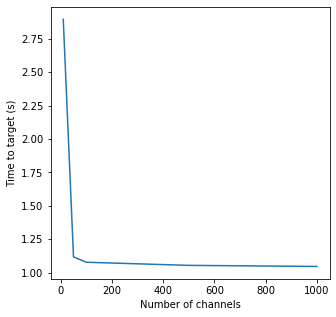

In [4]:
figSize(5, 5)
import matplotlib.pyplot as plt

_ = plt.plot(channel_sweep, np.mean(session_scores, axis = 1))
plt.xlabel('Number of channels')
plt.ylabel('Time to target (s)')

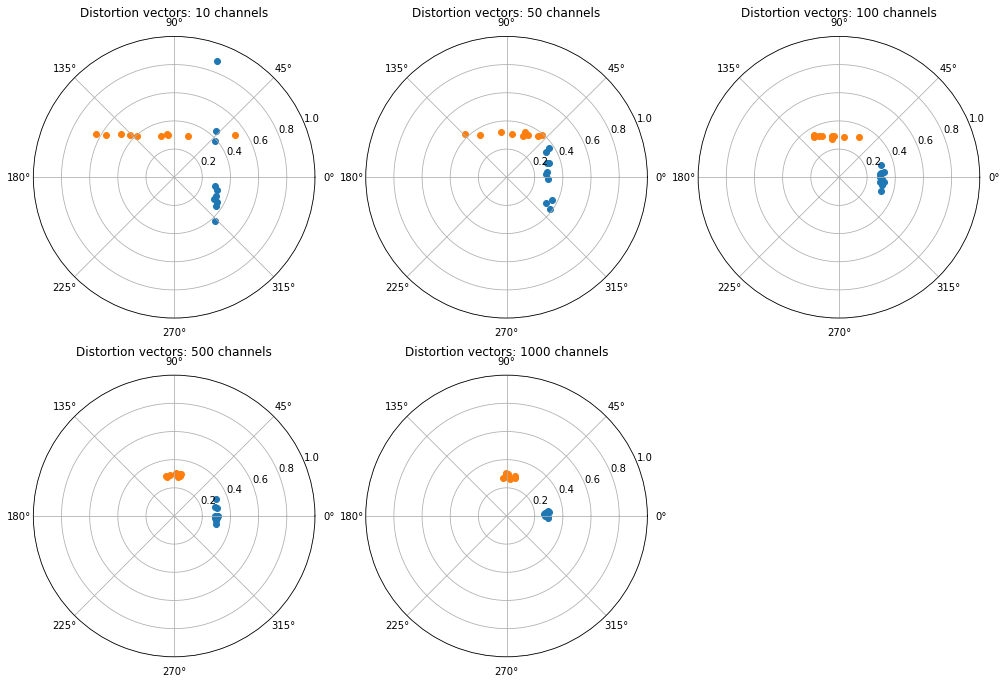

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

figSize(14, 14)

labels = ['X distortion vectors', 'Y distortion vectors']

for i, nUnits in enumerate(channel_sweep):
    plt.subplot(3, 3, i + 1, projection='polar')
    for j in range(2):
        theta = np.arctan2(distortion_mats[i, :, 1, j], distortion_mats[i, :, 0, j])
        r     = np.linalg.norm(distortion_mats[i, :, :, j], axis = 1)
        plt.scatter(theta, r, )
        ax    = plt.gca()
        ax.set_rlim([0, 1])
    plt.title('Distortion vectors: ' + str(nUnits) + ' channels')
    
plt.tight_layout()